In [1]:
from __future__ import annotations
from typing import TYPE_CHECKING

if TYPE_CHECKING:
    from typing import TypedDict

    class SentimentConfig(TypedDict):
        use_chi2: bool
    
    class ReturnConvertEmojis(TypedDict):
        total_emoji: bool
        text: str

#### Import all datasets of All Pulau Kumala's Infrastructures
All datasets will be concated into one single dataframe. It'll be necessary to have same dimension of columns to avoid further data error in processing. All datasets that used with variant total of rows is:
- `dataset_arena_balap_gokart.csv`: 1 rows.
- `dataset_candi_naga_lembuswana.csv`: 1 rows.
- `dataset_dayak_experience_center.csv`: 25 rows.
- `dataset_jembatan_penyebrangan_pulau_kumala.csv`: 1 rows.
- `dataset_kumala_central_park.csv`: 1 rows.
- `dataset_kumala_island.csv`: 1 rows.
- `dataset_patung_lembuswana_area_sps.csv`: 1 rows.
- `dataset_pulau_kumala.csv`: 1 rows.
- `dataaset_sky_tower_kumala.csv`: 1 rows.
- `dataset_taman_air_mancur_pulau_kumala.csv`: 1 rows.
- `dataset_wisata_tenggarong_kolam_naga.csv`: 1 rows.

In [2]:
# import all the necessary modules
import os
import re
import torch
import emoji
from glob import glob
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

d:\suarasiy\skripsi\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# configure the sentiment processing
sentiment_config: SentimentConfig = {
    "use_chi2": True,
}

In [4]:
# Define function for pre-processing

# return None if the review is "[no_review]"
def remove_empty_review (review: str) -> str:
    return None if review == "[no_review]" else review

# remove urls from the text contain urls
def remove_urls (text: str):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# convert emoji to meaningful text
def convert_emojis (text: str):
    return emoji.demojize(text)

# convert emoji to meaningful text
# def convert_emojis (text: str) -> ReturnConvertEmojis:
#     return {
#         'total_emoji': emoji.emoji_count(text),
#         'text': emoji.demojize(text)
#     }

In [5]:
# initialize path to datasets
path_to_datasets = "{}\\datasets".format(os.getcwd())
all_datasets = (pd.read_csv(f) for f in glob(os.path.join(path_to_datasets, "*.csv")))

# concatenate all the datasets
data = pd.concat(all_datasets, ignore_index=True)

# select only columns "review"
data = data[["review"]]

In [ ]:
# # remove empty reviews by value "[no_review]", then drop the rows with NaN values
# data['review'] = data['review'].apply(remove_empty_review)
# data = data.dropna(subset=['review'], ignore_index=True)

# data

In [8]:
# # Sample data for product prices in 2021, 2022, and 2023
# s = {'Product': ['Laptop', 'Smartphone', 'Tablet', 'Smartwatch', 'Headphones'],
#         'Price_2021': [1300, 850, 420, 260, 150],
#         'Price_2022': [1200, 800, 350, 250, 150],
#         'Price_2023': [1100, 750, 380, 240, 150]}

# product_prices = pd.DataFrame(s)

In [8]:
# # Comparing two columns (Price_2022 and Price_2023)
# price_comparison = product_prices['Price_2022'] > product_prices['Price_2023']

# print(price_comparison)

In [9]:
# data['cleaned_url'] = data['review'].apply(remove_urls)

In [9]:
# data_has_urls = data['review'] != data['cleaned_url']
# sum(not bool(x) for x in data_has_urls)

In [ ]:
# ketambahan filter & normalisasi

In [6]:
# pre-processing the data

# remove empty reviews by value "[no_review]", then drop the rows with NaN values
data['review'] = data['review'].apply(remove_empty_review)
data = data.dropna(subset=['review'])

# remove urls
data['review'] = data['review'].apply(remove_urls)

# convert emojis
data['review'] = data['review'].apply(convert_emojis)
# review_converted_emojis = data['review'].apply(convert_emojis)
# data['review_no_emojis'] = review_converted_emojis

In [7]:
data

,review
0,"OK, I have it"
1,The place is good for taking photos
2,One of the tourist destinations on Kumala Isla...
3,A unique and interesting island located in the...
4,Hopefully I can walk here again
...,...
576,Reasonable
577,Awesome
578,Pleasant
579,"Tenggarong, East Kalimantan"


In [ ]:
# convert emojis
review_converted_emojis = data['review'].apply(convert_emojis)
# sum([x['total_emoji'] for x in review_converted_emojis])
review_converted_emojis

In [43]:
asd = sum([x['total_emoji'] for x in review_converted_emojis if x['total_emoji'] > 0])
# asd
abs(33 - data.shape[0])

459

In [8]:
data

,review
0,"OK, I have it"
1,The place is good for taking photos
2,One of the tourist destinations on Kumala Isla...
3,A unique and interesting island located in the...
4,Hopefully I can walk here again
...,...
576,Reasonable
577,Awesome
578,Pleasant
579,"Tenggarong, East Kalimantan"


In [8]:
# tokenize with nlptown/bert-base-multilingual-uncased-sentiment tokenizer and model
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Define function to tokenize the reviews
def predict_sentiment(review: str):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # get the predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    return predicted_label

# giving labels to the reviews
data['sentiment'] = data['review'].apply(predict_sentiment)

In [9]:
# Define function to tokenize the reviews
def extract_features(review: str):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states

    # Use the [CLS] token embedding as the sentence embedding
    cls_embedding = hidden_states[-1][:, 0, :].squeeze().numpy()

    return cls_embedding

# extract features from the reviews
data['features'] = data['review'].apply(extract_features)

In [10]:
data

,review,sentiment,features
0,"OK, I have it",2,"[0.021978065, 0.07565795, -0.057591636, -0.515..."
1,The place is good for taking photos,3,"[-0.2428127, -0.61732364, -0.2426435, 0.095686..."
2,One of the tourist destinations on Kumala Isla...,3,"[0.16553363, -0.21731222, -0.16979444, 0.08522..."
3,A unique and interesting island located in the...,3,"[0.4399781, -0.5964806, -0.17686953, 0.4701182..."
4,Hopefully I can walk here again,3,"[-0.06928304, -0.2841256, -0.19580573, -0.4608..."
...,...,...,...
576,Reasonable,2,"[-0.5042372, -0.09283149, -0.06390904, -0.4116..."
577,Awesome,4,"[0.3056418, -0.7073638, -0.5004514, -0.1590952..."
578,Pleasant,3,"[-0.40046605, -0.6054412, -0.14516467, -0.0016..."
579,"Tenggarong, East Kalimantan",3,"[0.007266119, -0.15634911, -0.08427003, -0.076..."


In [11]:
# define target features and sentiment labels
X = np.stack(data['features'])
y = data['sentiment']

# scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
X_scaled.shape[1]

768

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the range of K values to test
n_features = X_scaled.shape[1]
# k_values = list(range(100, 800, 50)) + [X_scaled.shape[1]]
k_values = [int(n_features * ratio) for ratio in np.arange(0.1, 1.1, 0.1)]

# Create a pipeline with SelectKBest and MultinomialNB

pipeline = Pipeline([
    ('selector', SelectKBest(chi2)),
    ('classifier', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'selector__k': k_values
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y)

# Get the best K value and the corresponding accuracy
best_k = grid_search.best_params_['selector__k']
best_score = grid_search.best_score_

# Log all cross-validation accuracy values
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"K={params['selector__k']}, Cross-Validation Accuracy={mean_score:.4f}")

print(f"Best K value: {best_k}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

K=76, Cross-Validation Accuracy=0.7156
K=153, Cross-Validation Accuracy=0.7461
K=230, Cross-Validation Accuracy=0.7786
K=307, Cross-Validation Accuracy=0.7867
K=384, Cross-Validation Accuracy=0.8112
K=460, Cross-Validation Accuracy=0.8295
K=537, Cross-Validation Accuracy=0.8478
K=614, Cross-Validation Accuracy=0.8457
K=691, Cross-Validation Accuracy=0.8760
K=768, Cross-Validation Accuracy=0.8720
Best K value: 691
Best cross-validation accuracy: 0.8760


In [14]:
# Define the refined range of K values around the initial best K value
refined_k_values = list(range(best_k - 20, best_k + 21, 1))

# Create a pipeline with SelectKBest and MultinomialNB
pipeline = Pipeline([
    ('selector', SelectKBest(chi2)),
    ('classifier', MultinomialNB())
])

# Define the parameter grid
refined_param_grid = {
    'selector__k': refined_k_values
}

# Perform grid search with cross-validation
refined_grid_search = GridSearchCV(pipeline, refined_param_grid, cv=5, scoring='accuracy')
refined_grid_search.fit(X_scaled, y)

# Get the best K value and the corresponding accuracy
refined_best_k = refined_grid_search.best_params_['selector__k']
refined_best_score = refined_grid_search.best_score_

# Log all cross-validation accuracy values
refined_cv_results = refined_grid_search.cv_results_
for mean_score, params in zip(refined_cv_results['mean_test_score'], refined_cv_results['params']):
    print(f"K={params['selector__k']}, Cross-Validation Accuracy={mean_score:.4f}")

print(f"Refined Best K value: {refined_best_k}")
print(f"Refined Best cross-validation accuracy: {refined_best_score:.4f}")

K=671, Cross-Validation Accuracy=0.8781
K=672, Cross-Validation Accuracy=0.8801
K=673, Cross-Validation Accuracy=0.8781
K=674, Cross-Validation Accuracy=0.8781
K=675, Cross-Validation Accuracy=0.8781
K=676, Cross-Validation Accuracy=0.8781
K=677, Cross-Validation Accuracy=0.8781
K=678, Cross-Validation Accuracy=0.8781
K=679, Cross-Validation Accuracy=0.8781
K=680, Cross-Validation Accuracy=0.8781
K=681, Cross-Validation Accuracy=0.8781
K=682, Cross-Validation Accuracy=0.8781
K=683, Cross-Validation Accuracy=0.8781
K=684, Cross-Validation Accuracy=0.8781
K=685, Cross-Validation Accuracy=0.8781
K=686, Cross-Validation Accuracy=0.8781
K=687, Cross-Validation Accuracy=0.8781
K=688, Cross-Validation Accuracy=0.8781
K=689, Cross-Validation Accuracy=0.8760
K=690, Cross-Validation Accuracy=0.8760
K=691, Cross-Validation Accuracy=0.8760
K=692, Cross-Validation Accuracy=0.8760
K=693, Cross-Validation Accuracy=0.8760
K=694, Cross-Validation Accuracy=0.8760
K=695, Cross-Validation Accuracy=0.8760


In [ ]:
# Define the range of K values to test
n_features = X_scaled.shape[1]
k_values = list(range(100, 800, 10)) + [X_scaled.shape[1]]

# Create a pipeline with SelectKBest and MultinomialNB

pipeline = Pipeline([
    ('selector', SelectKBest(chi2)),
    ('classifier', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'selector__k': k_values
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y)

# Get the best K value and the corresponding accuracy
best_k = grid_search.best_params_['selector__k']
best_score = grid_search.best_score_

print(f"Best K value: {best_k}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

In [15]:
# perform chi-square feature selection with best K features
# selector = SelectKBest(chi2, k=500)
selector = SelectKBest(chi2, k=refined_best_k)
X_selected = selector.fit_transform(X_scaled, y)

In [23]:
# check if chi-square feature selection is enabled
if sentiment_config["use_chi2"]:
    X_scaled = X_selected

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

# train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      1.00      1.00         6
           2       0.85      0.89      0.87        19
           3       0.91      0.84      0.87        37
           4       0.90      0.90      0.90        31

    accuracy                           0.89        99
   macro avg       0.88      0.93      0.90        99
weighted avg       0.89      0.89      0.89        99



In [24]:
from sklearn.feature_selection import mutual_info_classif

In [25]:
mi_selector = SelectKBest(mutual_info_classif, k=refined_best_k)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

In [26]:
model_mi = MultinomialNB()
model_mi.fit(X_train_mi, y_train)
y_pred_mi = model_mi.predict(X_test_mi)
accuracy_mi = accuracy_score(y_test, y_pred_mi)
print("Accuracy with mutual information feature selection:", accuracy_mi)

Accuracy with mutual information feature selection: 0.898989898989899


In [ ]:
X_selected

In [ ]:
# Create a DataFrame for the selected features
# selected_features_df = pd.DataFrame(X_selected, columns=[f'Feature {i}' for i in range(X_selected.shape[1])])
# selected_features_df['Target'] = y

# Visualize the selected features
# sns.pairplot(selected_features_df, hue='Target')
# plt.suptitle('Selected Features', y=1.02)
# plt.show()

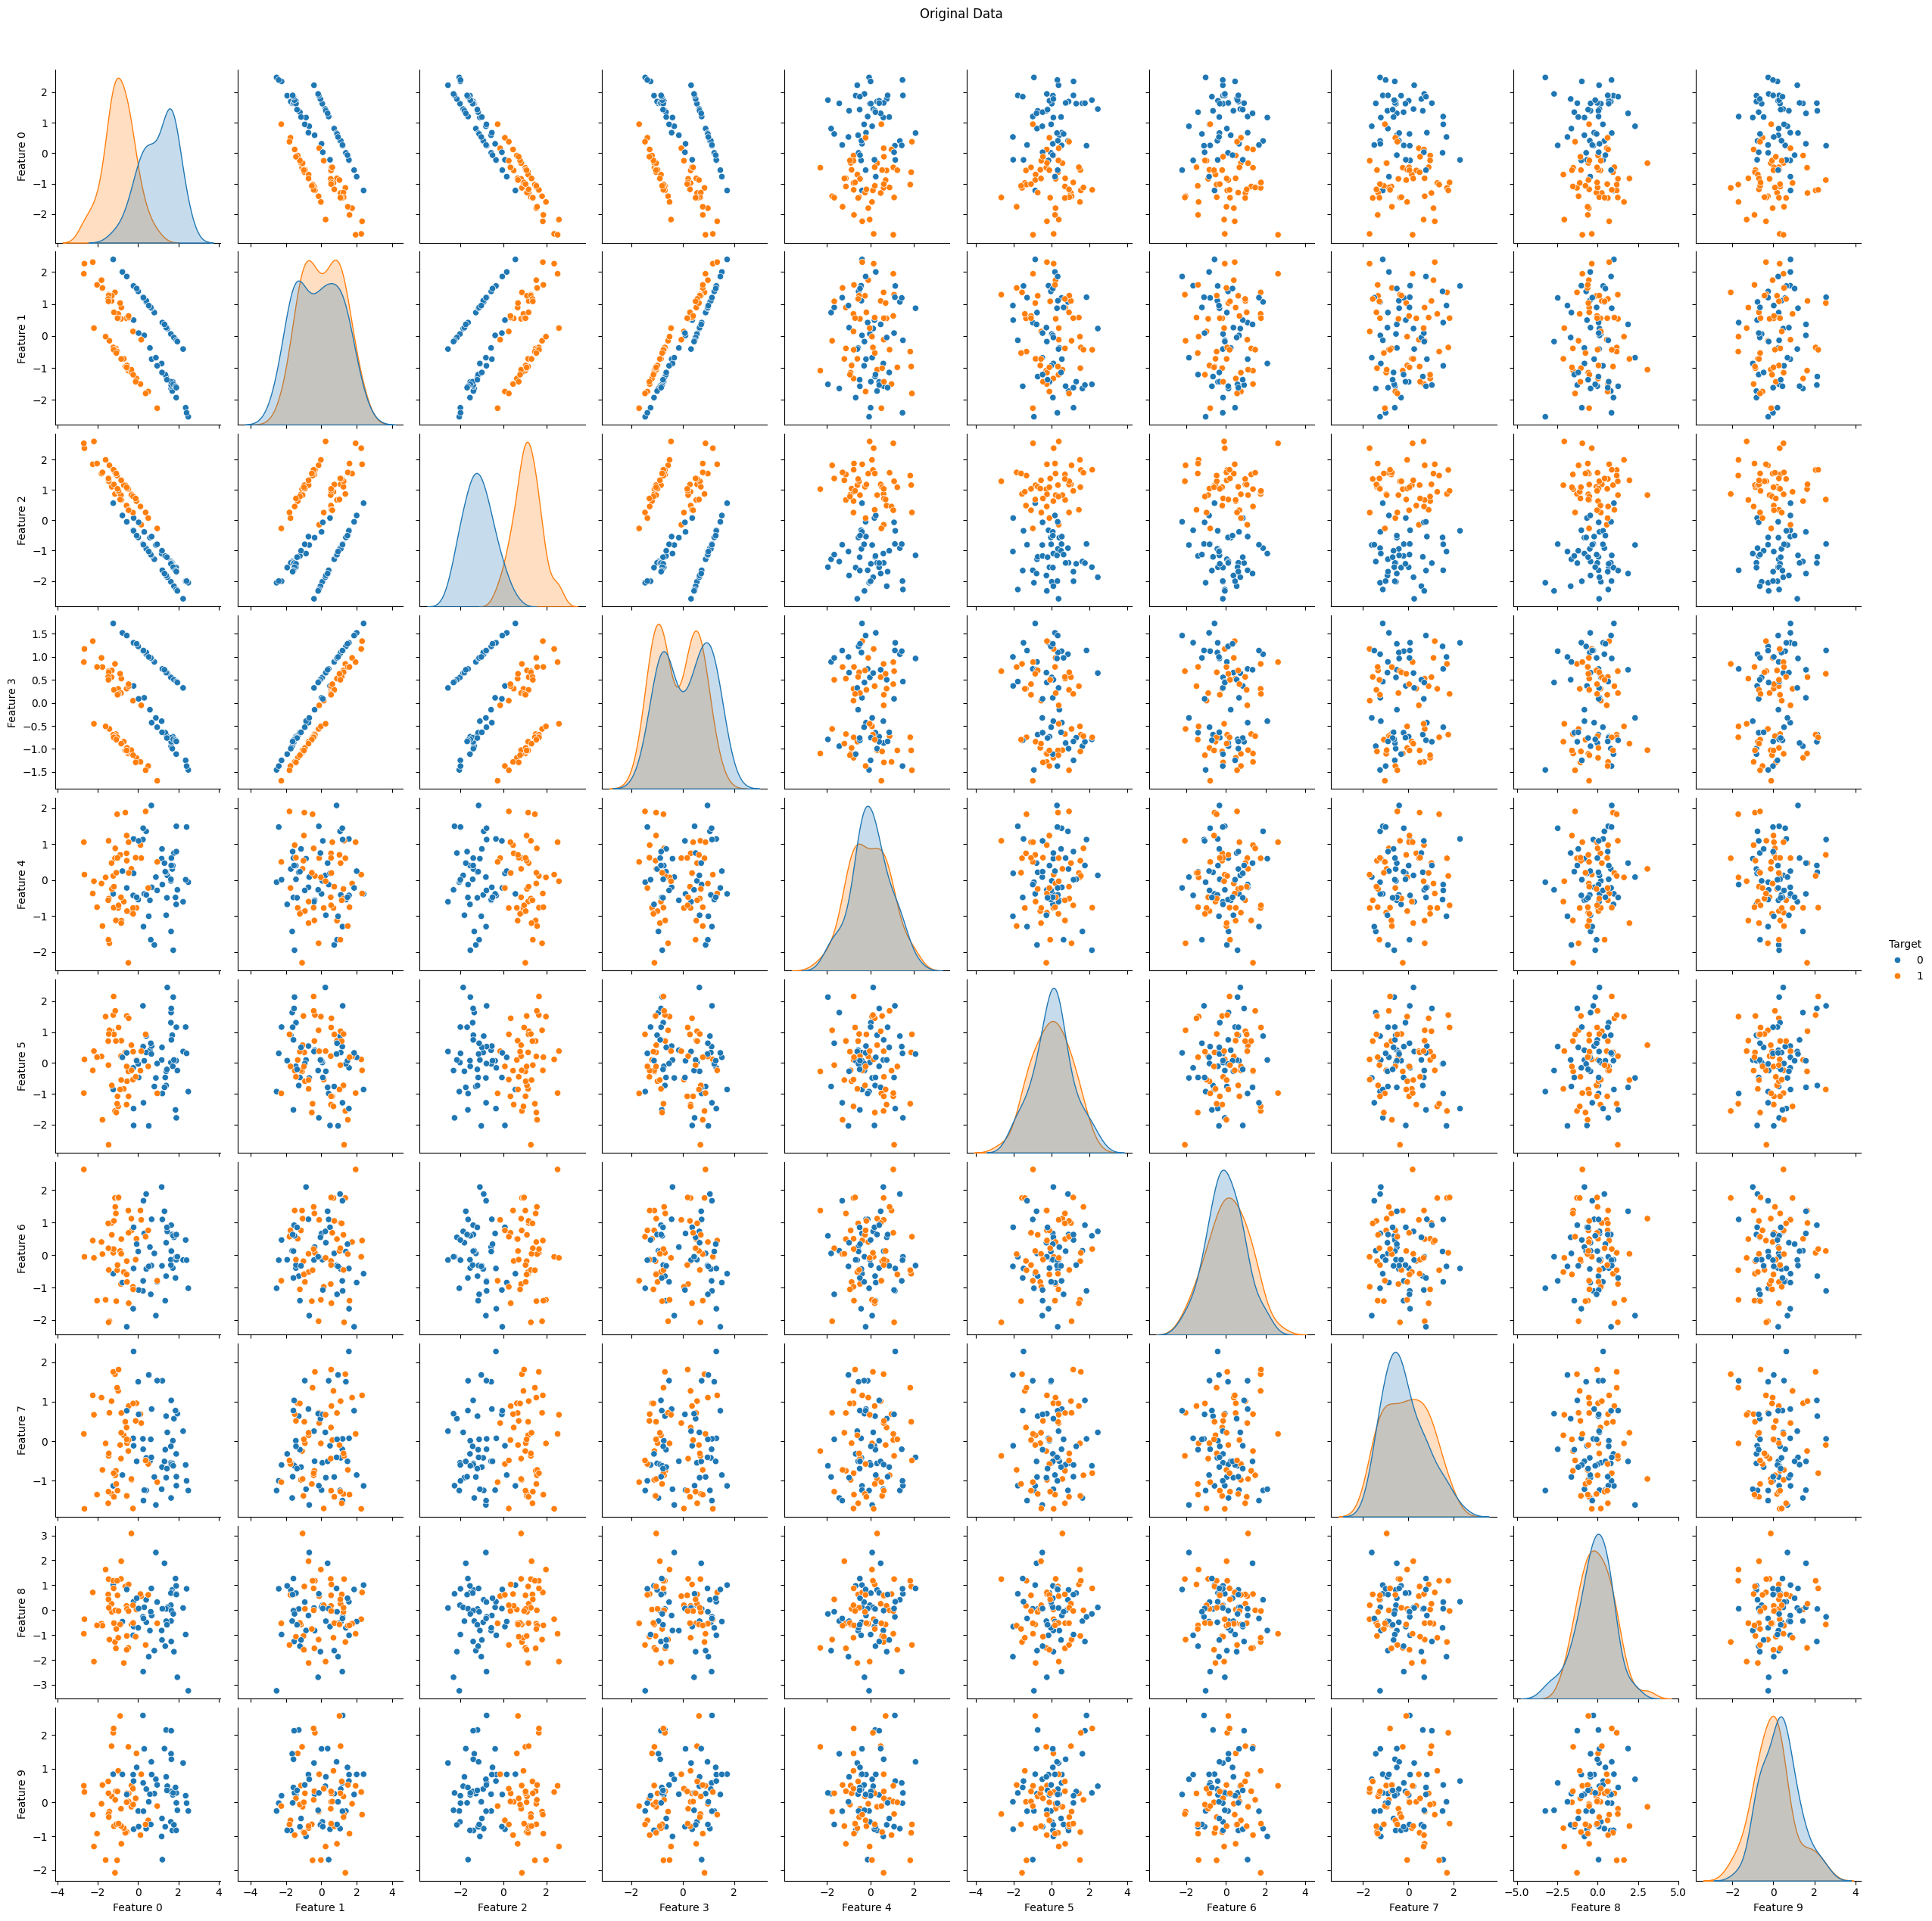

ValueError: Input X must be non-negative.

In [16]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Generate a synthetic dataset
X, y = make_classification(n_samples=100, n_features=10, random_state=42)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y

# Visualize the original data
sns.pairplot(df, hue='Target')
plt.suptitle('Original Data', y=1.02)
plt.show()

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply chi-square selector
selector = SelectKBest(chi2, k=5)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]

# Create a DataFrame for the selected features
df_selected = pd.DataFrame(X_selected, columns=selected_features)
df_selected['Target'] = y

# Visualize the selected features
sns.pairplot(df_selected, hue='Target')
plt.suptitle('Selected Features After Scaling and Chi-Square Selection', y=1.02)
plt.show()

In [193]:
from matplotlib.colors import BoundaryNorm

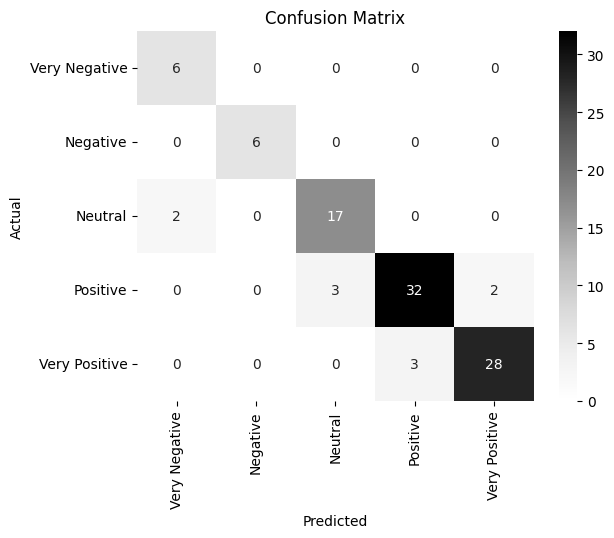

In [292]:
# Define the mapping of sentiment labels to their respective names
sentiment_mapping = {
    0: 'Very Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Very Positive'
}

# Map the sentiment column to their respective names
data['sentiment_label'] = data['sentiment'].map(sentiment_mapping)


# Plot the confusion matrix with sentiment labels
cm = confusion_matrix(y_test, y_pred)

plt.style.use('default')

sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=sentiment_mapping.values(), yticklabels=sentiment_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# plt.gcf().set_facecolor('#0b2651')
plt.show()

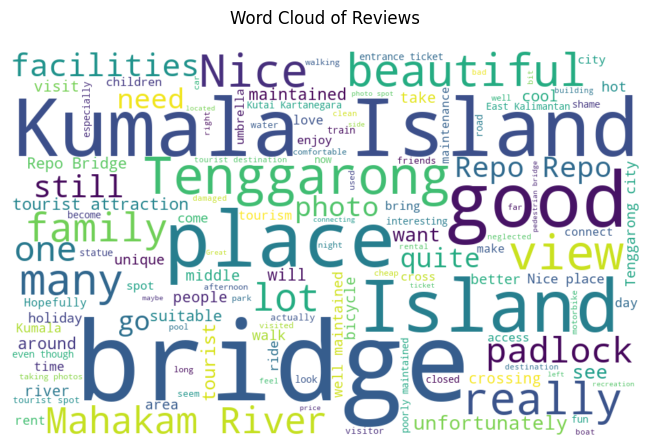

In [309]:
# Combine all reviews into a single string
all_reviews = ' '.join(data['review'])

# Generate the word cloud
wordcloud = WordCloud(width=900, height=550, background_color='white', stopwords=None, min_font_size=10).generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews', pad=20)
plt.show()

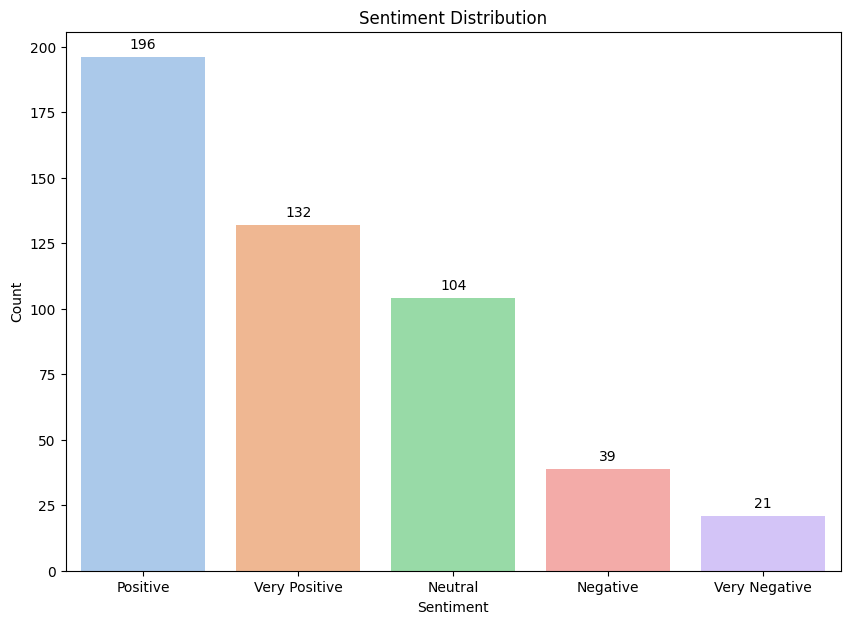

In [16]:
# Count the occurrences of each sentiment label
sentiment_counts = data['sentiment_label'].value_counts()

# Plot the sentiment distribution as a bar chart
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel', hue=sentiment_counts.index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

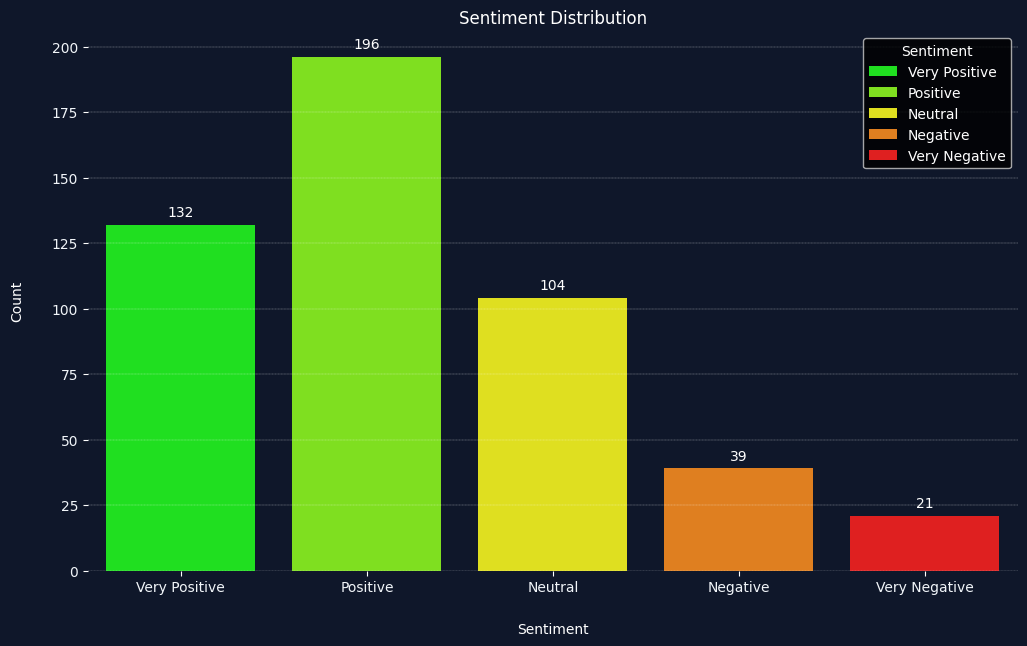

In [177]:
# Define custom colors for each sentiment label
custom_colors = {
    'Very Positive': '#00FF00',  # Green
    'Positive': '#7FFF00',       # Light Green
    'Neutral': '#FFFF00',        # Yellow
    'Negative': '#FF7F00',       # Orange
    'Very Negative': '#FF0000',  # Red
}

# Count the occurrences of each sentiment label
sentiment_counts = data['sentiment_label'].value_counts()

# Re-order sentiment based on custom_colors' keys
ordered_sentiment = { k: sentiment_counts[k] for k in custom_colors.keys()}

# Plot the sentiment distribution as a bar chart with custom colors
plt.style.context('dark_background')
plt.figure(figsize=(12, 7), clear=True, facecolor='#0f172a')
plt.box(on=False)
plt.grid(visible=True, color=(1, 1, 1, 0.1), linestyle='--', linewidth=.2)
ax = sns.barplot(x=ordered_sentiment.keys(), y=ordered_sentiment.values(), palette=custom_colors, hue=ordered_sentiment.keys())
ax.tick_params(labelcolor='#f1f5f9')

for bar, label in zip(ax.patches, ordered_sentiment.keys()):
    bar.set_label(label)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.xlabel('Sentiment', labelpad=20)
plt.ylabel('Count', labelpad=20)
plt.title('Sentiment Distribution')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

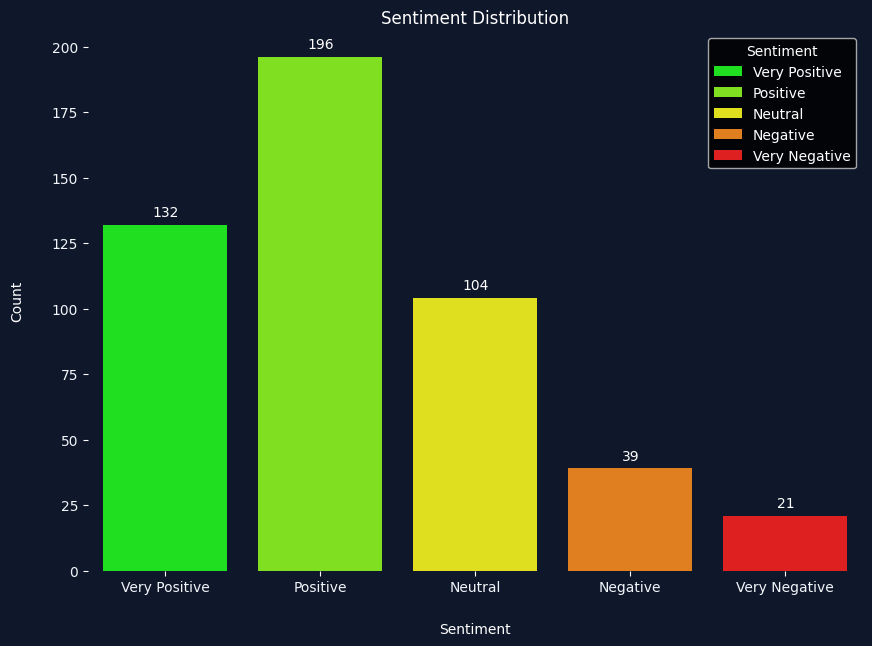

In [149]:
# Re-order sentiment_counts.items() following custom_colors property
ordered_sentiment_counts = {k: sentiment_counts[k] for k in custom_colors.keys()}

# Plot the sentiment distribution as a bar chart with custom colors
plt.figure(figsize=(10, 7), clear=True, facecolor='#0f172a')
plt.box(on=False)
ax = sns.barplot(x=list(ordered_sentiment_counts.keys()), y=list(ordered_sentiment_counts.values()), palette=custom_colors, hue=list(ordered_sentiment_counts.keys()))
ax.tick_params(labelcolor='#f1f5f9')

for bar, label in zip(ax.patches, ordered_sentiment_counts.keys()):
    bar.set_label(label)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.xlabel('Sentiment', labelpad=20)
plt.ylabel('Count', labelpad=20)
plt.title('Sentiment Distribution')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

In [ ]:
# additional save the model

# save the model
# torch.save(model, 'model.pt')

# save the tokenizer
# tokenizer.save_pretrained('tokenizer')

# save the scaler
# torch.save(scaler, 'scaler.pt')

# save the selector
# torch.save(selector, 'selector.pt')

# save the data
# data.to_csv('data.csv', index=False)

In [20]:
# initialize path to datasets
path_to_datasets = "{}\\datasets".format(os.getcwd())
all_datasets = (pd.read_csv(f) for f in glob(os.path.join(path_to_datasets, "*.csv")))

# concatenate all the datasets
data = pd.concat(all_datasets, ignore_index=True)

# select only columns "review"
# data = data[["review"]]
data.head()

,name,review,contrib,humanized_timestamp,minires_images,stars.label,stars.value
0,Fachrul Rozie F,"OK, I have it",Local Guide · 60 reviews · 65 photos,a year ago,[no_minires_images],5 stars,5
1,Fachrul Rozie F,The place is good for taking photos,Local Guide · 60 reviews · 65 photos,a year ago,[no_minires_images],5 stars,5
2,baim Journey,One of the tourist destinations on Kumala Isla...,Local Guide · 99 reviews · 400 photos,6 years ago,['https://lh3.googleusercontent.com/geougc-cs/...,5 stars,5
3,Teras,A unique and interesting island located in the...,"Local Guide · 595 reviews · 3,079 photos",4 years ago,[no_minires_images],5 stars,5
4,Oktoberianto Wonodiharjo,Hopefully I can walk here again,"Local Guide · 690 reviews · 6,593 photos",3 years ago,['https://lh3.googleusercontent.com/geougc-cs/...,4 stars,4


In [16]:
# initialize path to datasets
path_to_datasets = "{}\\datasets".format(os.getcwd())
# all_datasets = (f for f in glob(os.path.join(path_to_datasets, "*.csv")))

# concatenate all the datasets
# data = pd.concat(all_datasets, ignore_index=True)

# select only columns "review"
# data = data[["review"]]

In [14]:
all_datasets = [f for f in glob(os.path.join(path_to_datasets, "*.csv"))]

ti = 5
d = pd.read_csv(all_datasets[ti])
print('{}: {} rows.'.format(all_datasets[ti], d.shape[0]))

# d.head()

# for dataset in all_datasets:
#     data = pd.read_csv(dataset)
#     data.head()

# print(x[0])

d:\suarasiy\skripsi\datasets\dataset_kumala_island.csv: 65 rows.
